# Algoritmi supervisionati

## In questa sezione vengono applicati gli algoritmi supervisionati

### Import delle librerie e moduli necessari

In [25]:
# librerie generali
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# librerie per la rappresentazione del dataset
from sklearn.feature_extraction.text import TfidfVectorizer

# libreria per suddividere il dataset in train e test set
from sklearn.model_selection import train_test_split

# libreria utilizzata per l'ottimizzazione dei parametri
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# librerie utilizzate per le misure
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

# libreria utilizzata per la cross validation
from sklearn.model_selection import cross_val_score

# libreria per il Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# libreria utilizzata per il Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# libreria utilizzata per il KNN
from sklearn.neighbors import KNeighborsClassifier

# libreria utilizzata per la rete neurale
from sklearn.neural_network import MLPClassifier

# libreria utilizzata per il support vector machine
from sklearn.svm import SVC

# libreria utilizzata per l'ensamble learning
from sklearn.ensemble import StackingClassifier

import pickle

# seed utilizzato per la generazione del train e test set
random_seed = 3

# 1. Creazione dataset con rappresentazione tf-idf

In [6]:
clean_dataset = pd.read_csv("../datasets/clean_dataset.csv", index_col=0)
clean_dataset.head()

,rating,reviewText,summary,sentiment,numberPositiveReview,numberNegativeReview,numberPositiveSummary,numberNegativeSummary
0,3,jace rankin may short nothing mess man haul sa...,entertaining average,0,0.06,0.11,0.50,0.00
1,5,great short read want put read one sit sex sce...,terrific menage scene,1,0.19,0.03,0.33,0.00
2,3,ill start say first four book expect 34conclud...,snapdragon alley,0,0.05,0.02,0.00,0.00
3,3,aggie angela lansbury carry pocketbook instead...,light murder cozy,0,0.10,0.13,0.33,0.33
4,4,expect type book library please find price right,book,1,0.12,0.00,0.00,0.00


In [7]:
def createDataframeWithTfIdf(dataframe):
    reviewText = dataframe['reviewText'].to_numpy()
    vectorizer = TfidfVectorizer(sublinear_tf=True)
    tfidf_vector = vectorizer.fit_transform(reviewText)
    tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=reviewText, columns=vectorizer.get_feature_names())
    
    tfidf_df['numberPositiveReview'] = dataframe['numberPositiveReview'].to_numpy()
    tfidf_df['numberNegativeReview'] = dataframe['numberNegativeReview'].to_numpy()
    tfidf_df.reset_index(drop=True, inplace=True)
    sentiment = dataframe['sentiment']
    return tfidf_df, sentiment

In [8]:
dataset, labels = createDataframeWithTfIdf(clean_dataset)

In [9]:
print(dataset.shape)

(11891, 41387)


# 2. Definizione della funzione K-fold cross validation

## Questa funzione viene utilizzata per effettuare la K-fold cross validation sui varia classificatori. La cross validation viene effettuata per valori di k in [10, 15]

In [10]:
def kCrossValidation(model, dataset, labels):
    k = []
    acc = []
    dev = []

    #nota, non viene effettuato lo shuffle dei fold, quindi sono sempre gli stessi, sono già istanziati
    for i in range(10, 16):
        scores = cross_val_score(model, dataset, labels, cv=i)
        print("K cross validation, k= ", i)
        k.append(i)
        print("Average scores: ", scores.mean())
        acc.append(scores.mean())
        print("Standard Deviation of scores: ", scores.std())
        dev.append(scores.std())
        print("\n\n")

In [11]:
def kCrossValidationReduced(model, dataset, labels):
    k = []
    acc = []
    dev = []

    folds = [5, 10]
    #nota, non viene effettuato lo shuffle dei fold, quindi sono sempre gli stessi, sono già istanziati
    for i in folds:
        print("Calculating with " + str(i) + " folds...")
        scores = cross_val_score(model, dataset, labels, cv=i)
        print("K cross validation, k= ", i)
        k.append(i)
        print("Average scores: ", scores.mean())
        acc.append(scores.mean())
        print("Standard Deviation of scores: ", scores.std())
        dev.append(scores.std())
        print("\n\n")

## 2.1 Definizione funzione per la visualizzazione dei grafici

In [12]:
def report_scores(Y_test, y_predicted):
    #print("Accuracy score: ", accuracy_score(Y_test, y_predicted))
    print(classification_report(Y_test, y_predicted, target_names=["Negativo", "Positivo"]))
    
    cf_matrix = confusion_matrix(Y_test, y_predicted)

    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Negativo','Positivo'])
    ax.yaxis.set_ticklabels(['Negativo','Positivo'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

# 3. Random Forest

## 3.1 Random Forest: Feature Selection

### Prima di applicare il random forest per la classificazione, viene effettuata la feature selection per estrarre le feature più importanti, avendo il dataset nella rappresentazione tf-idf

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset, labels, test_size=0.2, random_state=random_seed)
    
rf = RandomForestClassifier(criterion = 'entropy', random_state=random_seed)
rf.fit(X_train, Y_train)
y_pred=rf.predict(X_test)

# feature selection
sel = SelectFromModel(rf, prefit=True)
selected_feat = dataset.columns[(sel.get_support())]
print("Numero feature selezionate: " + str(len(selected_feat)))

featureSelection_df = dataset.loc[:, sel.get_support()]

Numero feature selezionate: 3410


In [14]:
featureSelection_df.to_csv("../datasets/featureSelectionReview_df.csv")

## 3.2 Random Forest: Parameter Tuning

### Dopo aver effettuato la feature selection, viene attuato il paramater tuning sulle feature più importanti tramite una ricerca esaustiva dello spazio di ricerca

### Parametri su cui viene effettuata la ricerca

In [18]:
n_estimators_list = [40,60,80,100]
criterion_list = ['entropy']
max_depth_list = [35,55]
max_depth_list.append(None)
min_samples_split_list = [15, 30]
min_samples_leaf_list = [5, 15, 30]
max_features_list = ['log2']

In [19]:
params_grid = {
    'n_estimators': n_estimators_list,
    'criterion': criterion_list,
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'min_samples_leaf': min_samples_leaf_list,
    'max_features': max_features_list
}

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)


def my_acc_score(model, truncated_df, labels):
    return metrics.accuracy_score(labels, model.predict(truncated_df))

### Salvataggio train-test-split

In [21]:
X_train.to_csv("../resources/X_train_Review.csv", index = False)
Y_train.to_csv("../resources/Y_train_Review.csv", index = False)
X_test.to_csv("../resources/X_test_Review.csv", index = False)
Y_test.to_csv("../resources/Y_test_Review.csv", index = False)

In [19]:
cross_validation = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)

### Ricerca dei parametri migliori

In [23]:
rf_searchParameter = GridSearchCV(estimator=RandomForestClassifier(random_state=random_seed),
                            param_grid=params_grid,
                            cv=cross_validation,
                            return_train_score=True,
                            verbose=2,
                            scoring = my_acc_score
                            )

rf_searchParameter.fit(X_train, Y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=40; total time=   0.4s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=40; total time=   1.0s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=40; total time=   0.5s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=60; total time=   0.8s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=60; total time=   0.8s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=60; total time=   0.7s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n

[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=60; total time=   0.4s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=60; total time=   0.4s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=60; total time=   0.3s
[CV] END criterion=

[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=100; total time=   0.8s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=100; total time=   0.8s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=40; total time=   0.3s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=40; total time=   0.2s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=60; total time=   0.4s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=60; total time=   0.3s
[CV] END criterion

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=100; total time=   0.8s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=100; total time=   0.8s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=100; total time=   0.9s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.4s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=60; total time=   0.5s
[CV

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
             estimator=RandomForestClassifier(random_state=3),
             param_grid={'criterion': ['entropy'], 'max_depth': [35, 55, None],
                         'max_features': ['log2'],
                         'min_samples_leaf': [5, 15, 30],
                         'min_samples_split': [15, 30],
                         'n_estimators': [40, 60, 80, 100]},
             return_train_score=True,
             scoring=<function my_acc_score at 0x0000018A6AA42E50>, verbose=2)

### Parametri migliori trovati

In [24]:
best_param = rf_searchParameter.best_params_
print("Parametri migliori trovati:\n")
for pair in best_param.items():
    print(pair)


Parametri migliori trovati:

('criterion', 'entropy')
('max_depth', None)
('max_features', 'log2')
('min_samples_leaf', 5)
('min_samples_split', 30)
('n_estimators', 100)


"\n('criterion', 'entropy')\n('max_depth', None)\n('max_features', 'log2')\n('min_samples_leaf', 5)\n('min_samples_split', 30)\n('n_estimators', 80)\n"

In [25]:
df_cv_results = pd.DataFrame(rf_searchParameter.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                           'param_n_estimators', 'param_min_samples_split','param_min_samples_leaf',
                           'param_max_features', 'param_max_depth','param_criterion']]
df_cv_results.sort_values('rank_test_score', inplace=True)
df_cv_results[:10]

,rank_test_score,mean_test_score,mean_train_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion
55,1,0.797203,0.893713,100,30,5,log2,None,entropy
51,2,0.795731,0.892399,100,15,5,log2,None,entropy
31,3,0.794786,0.881781,100,30,5,log2,55,entropy
50,4,0.793734,0.889718,80,15,5,log2,None,entropy
27,5,0.791947,0.881098,100,15,5,log2,55,entropy
3,6,0.791632,0.866432,100,15,5,log2,35,entropy
54,7,0.791211,0.891768,80,30,5,log2,None,entropy
26,8,0.791211,0.878890,80,15,5,log2,55,entropy
30,9,0.790160,0.879100,80,30,5,log2,55,entropy
7,10,0.789634,0.865854,100,30,5,log2,35,entropy


## 3.3 Random Forest: Classificazione

### Prendo i parametri migliori trovati per effettuare la classificazione

In [26]:
n_estimators_found = best_param.get('n_estimators')
max_depth_found = best_param.get('max_depth')
max_features_found = best_param.get('max_features')
min_samples_leaf_found = best_param.get('min_samples_leaf')
min_samples_split_found = best_param.get('min_samples_split')
criterion_found = best_param.get('criterion')

n_estimators_found = 100
max_depth_found = 55
max_features_found = 'log2'
min_samples_leaf_found = 5
min_samples_split_found = 15
criterion_found = 'entropy'

### Task di classificazione

In [27]:
rf = RandomForestClassifier(n_estimators = n_estimators_found, 
                            criterion = criterion_found,
                            class_weight= 'balanced',
                            max_depth= max_depth_found,
                            max_features= max_features_found,
                            min_samples_leaf= min_samples_leaf_found,
                            min_samples_split= min_samples_split_found,
                            random_state = random_seed
                           )
rf.fit(X_train, Y_train)

train_prediction = rf.predict(X_train)
test_prediction = rf.predict(X_test)

Accuracy train score:  0.8925567703952901
Accuracy test score:  0.7986548970155527
              precision    recall  f1-score   support

    Negativo       0.80      0.79      0.79      1172
    Positivo       0.80      0.81      0.80      1207

    accuracy                           0.80      2379
   macro avg       0.80      0.80      0.80      2379
weighted avg       0.80      0.80      0.80      2379



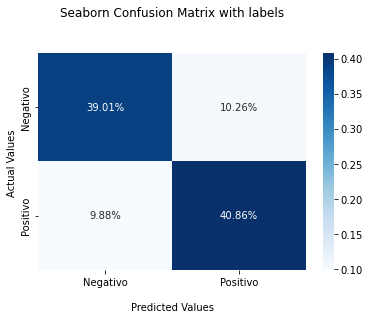

In [28]:
accuracy_train_rf = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_rf = metrics.accuracy_score(Y_test, test_prediction)

print("Accuracy train score: ", accuracy_train_rf)
print("Accuracy test score: ", accuracy_test_rf)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [29]:
kCrossValidation(rf, featureSelection_df, labels)

K cross validation, k=  10
Average scores:  0.8027078754125704
Standard Deviation of scores:  0.009337738202233523



K cross validation, k=  11
Average scores:  0.8026238331511226
Standard Deviation of scores:  0.0060503257080497625



K cross validation, k=  12
Average scores:  0.804810296031285
Standard Deviation of scores:  0.007535418145219767



K cross validation, k=  13
Average scores:  0.8055680493891203
Standard Deviation of scores:  0.01649715844700991



K cross validation, k=  14
Average scores:  0.8048101077886987
Standard Deviation of scores:  0.011062930562738429



K cross validation, k=  15
Average scores:  0.802541068524675
Standard Deviation of scores:  0.010694873237219602





# 4. Multinomial Naive Bayes

## Task di classificazione

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)
nb = MultinomialNB()
nb.fit(X_train, Y_train)

train_prediction = nb.predict(X_train)
test_prediction = nb.predict(X_test)

Accuracy train score:  0.8613330529857023
Accuracy test score:  0.8095838587641866
              precision    recall  f1-score   support

    Negativo       0.81      0.80      0.80      1172
    Positivo       0.81      0.82      0.81      1207

    accuracy                           0.81      2379
   macro avg       0.81      0.81      0.81      2379
weighted avg       0.81      0.81      0.81      2379



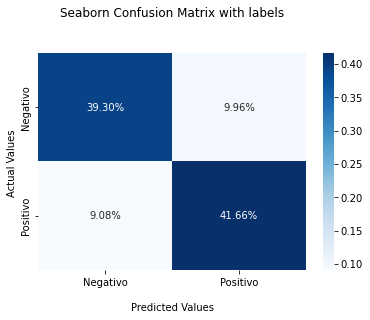

In [31]:
accuracy_train_nb = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_nb = metrics.accuracy_score(Y_test, test_prediction)

print("Accuracy train score: ", accuracy_train_nb)
print("Accuracy test score: ", accuracy_test_nb)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [32]:
kCrossValidation(nb, featureSelection_df, labels)

K cross validation, k=  10
Average scores:  0.8210414089942116
Standard Deviation of scores:  0.009380920807589802



K cross validation, k=  11
Average scores:  0.8216298040534858
Standard Deviation of scores:  0.009274363644520936



K cross validation, k=  12
Average scores:  0.822303424422496
Standard Deviation of scores:  0.009755446777498733



K cross validation, k=  13
Average scores:  0.8218822059909697
Standard Deviation of scores:  0.01186743622811197



K cross validation, k=  14
Average scores:  0.8201983549603588
Standard Deviation of scores:  0.011722897174245189



K cross validation, k=  15
Average scores:  0.8214627358069982
Standard Deviation of scores:  0.012304515712404951





# 5. KNN

## 5.1 Trovare il k migliore

### Prima di effettuare la classifcazione con il KNN, si cerca il valore k migliore che identifica il numero di neighbors su cui basarsi per la classficazione

### La ricerca di k viene effettuata per i seguenti valori: [9,11,13,15,17,19,97]

### Funzione che ricerca il k migliore

In [33]:
def findBestK(dataset, labels):
    X_train, X_test, Y_train, Y_test = train_test_split(dataset, labels, test_size=0.2, random_state=random_seed)
    error = []
    
    acc_train = []
    acc_test = []
    max_acc_test = 0
    max_acc_train = 0
    best_k = 0
    
    root = int(math.sqrt(X_train.shape[0]))
    k = [9,11,13,15,17,19]
    k.append(root)
    
    for i in k:
        print(str(i) + " Neighbors")
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, Y_train)
        pred_i = knn.predict(X_test)
        
        error.append(np.mean(pred_i != Y_test))
        
        print("train: ", knn.score(X_train, Y_train))
        print("test: ", knn.score(X_test, Y_test))
        acc_train.append(knn.score(X_train, Y_train))
        acc_test.append(knn.score(X_test, Y_test))
        print()
        if knn.score(X_train, Y_train) >= max_acc_train and knn.score(X_test, Y_test) >= max_acc_test:
            best_k = i
            max_acc_test = knn.score(X_test, Y_test)
            max_acc_train = knn.score(X_train, Y_train)
        
    print("\nErrori per i vari k:\n")
    print(error)
    
    x=[9,11,13,15,17,19,97]
    values = range(len(x))

    plt.figure(figsize=(12, 6))
    plt.xticks(values,x)
    plt.plot(values, error, color='red', linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10)
    plt.title('Error Rate K Value')
    plt.xlabel('K Value')
    plt.ylabel('Mean Error')

    return best_k

## 5.2 KNN: Classificazione

### Task di classificazione

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)


9 Neighbors
train:  0.8004625735912532
test:  0.6490121899957966

11 Neighbors
train:  0.7708158116063919
test:  0.6368221941992434

13 Neighbors
train:  0.7351766190075694
test:  0.6137032366540563

15 Neighbors
train:  0.6910218671152228
test:  0.6065573770491803

17 Neighbors
train:  0.663372582001682
test:  0.6015132408575031

19 Neighbors
train:  0.6385618166526493
test:  0.5897435897435898

97 Neighbors
train:  0.5759041211101766
test:  0.5825977301387137


Errori per i vari k:

[0.3509878100042034, 0.36317780580075665, 0.38629676334594365, 0.39344262295081966, 0.39848675914249687, 0.41025641025641024, 0.41740226986128626]


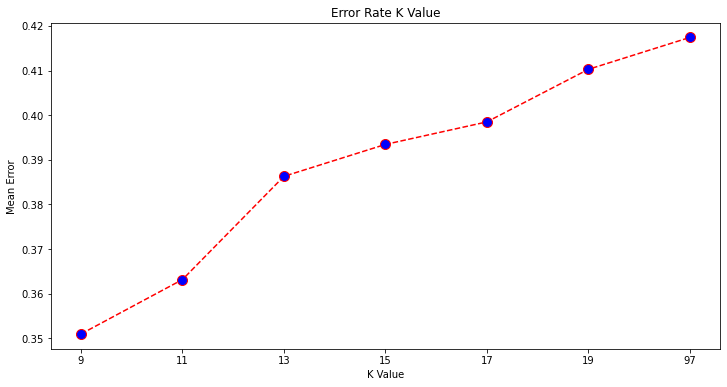

In [35]:
k = findBestK(featureSelection_df, labels)
knc = KNeighborsClassifier(n_neighbors=k, weights="distance")
knc.fit(X_train, Y_train)


train_prediction = knc.predict(X_train)
test_prediction = knc.predict(X_test)


Accuracy train score:  1.0
Accuracy test score:  0.6490121899957966
              precision    recall  f1-score   support

    Negativo       0.74      0.44      0.55      1172
    Positivo       0.61      0.85      0.71      1207

    accuracy                           0.65      2379
   macro avg       0.68      0.65      0.63      2379
weighted avg       0.68      0.65      0.63      2379



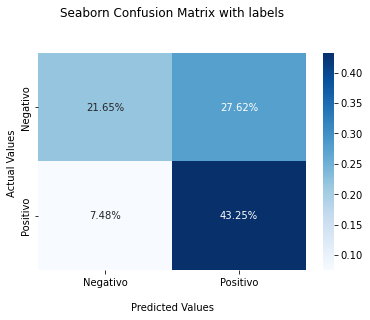

In [36]:
accuracy_train_knn = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_knn = metrics.accuracy_score(Y_test, test_prediction)

print("Accuracy train score: ", accuracy_train_knn)
print("Accuracy test score: ", accuracy_test_knn)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [37]:
kCrossValidation(knc, featureSelection_df, labels)

K cross validation, k=  10
Average scores:  0.634092981179015
Standard Deviation of scores:  0.022991555237832674



K cross validation, k=  11
Average scores:  0.6388865528551004
Standard Deviation of scores:  0.028403951548060934



K cross validation, k=  12
Average scores:  0.6337540388751286
Standard Deviation of scores:  0.02844427240698417



K cross validation, k=  13
Average scores:  0.6377965292590252
Standard Deviation of scores:  0.03069790872755282



K cross validation, k=  14
Average scores:  0.6346809395136147
Standard Deviation of scores:  0.03302835494890233



K cross validation, k=  15
Average scores:  0.6393062614374091
Standard Deviation of scores:  0.03040092557859474





# 6. Artificial Neural Network

## 6.1 Ottimizzazione dei parametri della rete neurale

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)

In [16]:
mlp = MLPClassifier(max_iter=200, random_state = random_seed)

### Paramatri su cui viene effettuata la ricerca

In [17]:
parameter_space = {
    'hidden_layer_sizes': [(200,150,100)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.005, 0.0001],
    'learning_rate': ['constant'],
    }

### Ricerca dei parametri

In [20]:
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=cross_validation)
clf.fit(X_train, Y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
             estimator=MLPClassifier(random_state=3), n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.005, 0.0001],
                         'hidden_layer_sizes': [(200, 150, 100)],
                         'learning_rate': ['constant'],
                         'solver': ['adam', 'sgd']})

### Parametri migliori trovati

In [21]:
print('Parametri migliori:\n', clf.best_params_)


Parametri migliori:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'}


"\n'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'\n"

In [22]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.788 (+/-0.001) for {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.554 (+/-0.015) for {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
0.792 (+/-0.009) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.554 (+/-0.014) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
0.760 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.502 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
0.767 (+/-0.017) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rat

## 6.2 Artificial Neural Network: Classificazione

### Prendo i parametri migliori trovati

In [26]:
best_params = clf.best_params_ 
with open('../resources/best_nn_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)


hidden_layer_sizes_found = best_params.get('hidden_layer_sizes')
activation_found = best_params.get('activation')
solver_found = best_params.get('solver')
alpha_found = best_params.get('alpha')
learning_rate_found = best_params.get('learning_rate')

hidden_layer_sizes_found = (200,150,100)
activation_found = 'relu'
solver_found = 'adam'
alpha_found = 0.005
learning_rate_found = 'constant'

### Task di classificazione

In [45]:
mlp = MLPClassifier(max_iter=500, 
                    random_state = random_seed,
                    hidden_layer_sizes = hidden_layer_sizes_found,
                    activation = activation_found,
                    solver = solver_found,
                    alpha = alpha_found,
                    learning_rate = learning_rate_found
                   )

mlp.fit(X_train, Y_train)

train_prediction = mlp.predict(X_train)
test_prediction = mlp.predict(X_test)

Accuracy train score:  1.0
Accuracy test score:  0.7994955863808323
              precision    recall  f1-score   support

    Negativo       0.80      0.78      0.79      1172
    Positivo       0.79      0.82      0.80      1207

    accuracy                           0.80      2379
   macro avg       0.80      0.80      0.80      2379
weighted avg       0.80      0.80      0.80      2379



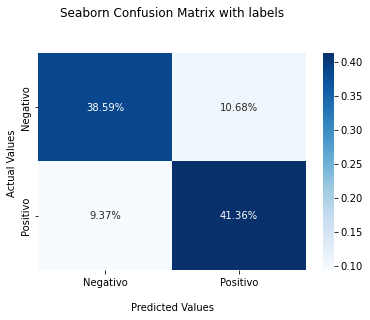

In [46]:
accuracy_train_nn = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_nn = metrics.accuracy_score(Y_test, test_prediction)

print("Accuracy train score: ", accuracy_train_nn)
print("Accuracy test score: ", accuracy_test_nn)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [55]:
kCrossValidationReduced(mlp, featureSelection_df, labels)

Calculating with 5 folds...
K cross validation, k=  5
Average scores:  0.7957278980538642
Standard Deviation of scores:  0.006639292495570709



Calculating with 10 folds...
K cross validation, k=  10
Average scores:  0.7991748591783223
Standard Deviation of scores:  0.01085190009647289





# 7. Support Vector Machine

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)

## Valori su cui ho ottimizzato il classificatore SVC

In [48]:
# valori su cui ho ottimizzato il classificatore SVC

# kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
# C_values = [0.5,1,10,100]
# gamma_values = ['scale', 1, 0.1, 0.01, 0.001, 0.0001]

# parametri migliori
kernel_found = 'linear'
C_found = 0.5
gamma_found = 0.0001

### Task di classificazione

In [49]:
svm = SVC(random_state=random_seed, kernel = kernel_found, C = C_found, gamma = gamma_found)
svm.fit(X_train, Y_train)

train_prediction = svm.predict(X_train)
test_prediction = svm.predict(X_test)

Accuracy train score:  0.8735281749369218
Accuracy test score:  0.8205128205128205
              precision    recall  f1-score   support

    Negativo       0.83      0.80      0.81      1172
    Positivo       0.81      0.84      0.83      1207

    accuracy                           0.82      2379
   macro avg       0.82      0.82      0.82      2379
weighted avg       0.82      0.82      0.82      2379



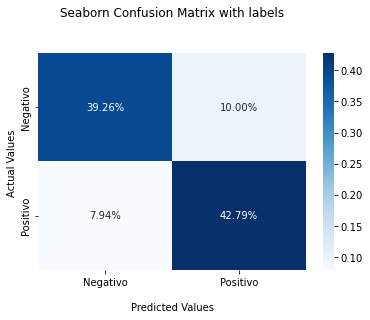

In [50]:
accuracy_train_svm = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_svm = metrics.accuracy_score(Y_test, test_prediction)

print("Accuracy train score: ", accuracy_train_svm)
print("Accuracy test score: ", accuracy_test_svm)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [56]:
kCrossValidationReduced(svm, featureSelection_df, labels)

Calculating with 5 folds...
K cross validation, k=  5
Average scores:  0.8225547977095633
Standard Deviation of scores:  0.0032504491505128434



Calculating with 10 folds...
K cross validation, k=  10
Average scores:  0.8212096175728492
Standard Deviation of scores:  0.008405487284374763





# 8. Confronto modelli

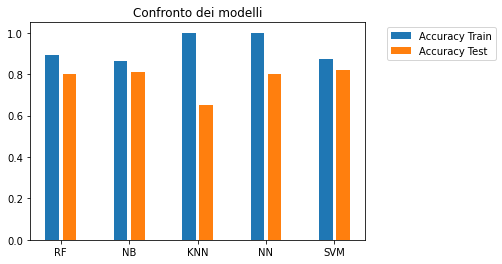

In [51]:
x_train = [1,5,9,13,17]
x_test = [2,6,10,14,18]

accuracy_train = [accuracy_train_rf, accuracy_train_nb, accuracy_train_knn, accuracy_train_nn, accuracy_train_svm]
accuracy_test = [accuracy_test_rf, accuracy_test_nb, accuracy_test_knn, accuracy_test_nn, accuracy_test_svm]

x_labels = [1.5,5.5,9.5,13.5,17.5]
name_labels = ["RF", "NB", "KNN", "NN", "SVM"]
plt.bar(x_train, accuracy_train, label='Accuracy Train')
plt.bar(x_test, accuracy_test, label='Accuracy Test')
plt.title("Confronto dei modelli")
plt.xticks(x_labels, name_labels)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 9. Ensamble learning

## In questa sezione vengono combinati i migliori classificatori ottenuti con l'ensamble learning

In [52]:
estimators = [['knn', knc], ['rf', rf], ['nb', nb], ['svm', svm]]

cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

clf = StackingClassifier(
    estimators=estimators, n_jobs = -1, cv = cross_validation)

clf.fit(X_train, Y_train)

train_prediction = clf.predict(X_train)
test_prediction = clf.predict(X_test)

Accuracy train score:  0.895605550883095
Accuracy test score:  0.8259773013871374
              precision    recall  f1-score   support

    Negativo       0.83      0.82      0.82      1172
    Positivo       0.82      0.84      0.83      1207

    accuracy                           0.83      2379
   macro avg       0.83      0.83      0.83      2379
weighted avg       0.83      0.83      0.83      2379



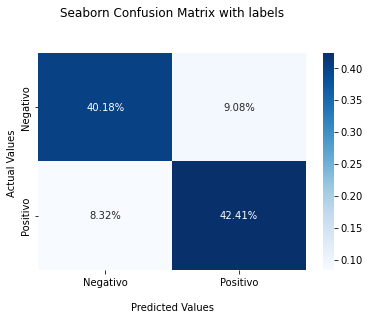

In [53]:
accuracy_train_clf = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_clf = metrics.accuracy_score(Y_test, test_prediction)

print("Accuracy train score: ", accuracy_train_clf)
print("Accuracy test score: ", accuracy_test_clf)

report_scores(Y_test, test_prediction)